In [1]:
from cmath import log
import uproot as up
import awkward as ak
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea import lookup_tools
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory, CorrectedMETFactory
from coffea.btag_tools.btagscalefactor import BTagScaleFactor
ak.behavior.update(candidate.behavior)
from template.temp_class import ntuplize
import numpy as np
import argparse
import os
from utils import common_helper as com
from utils import analyze_helper as ana
from coffea import hist as chist
import yaml

In [2]:
import numba as nb

@nb.jit(nopython=True)
def set_elec_fr_weight(pt,eta):
    if 10<pt<=20:
        if 0<abs(eta)<=1:
            return 0.430
        elif 1<abs(eta)<=1.5:
            return 0.345
        elif 1.5<abs(eta)<=2.0:
            return 0.207
        elif 2.0<abs(eta):
            return 0.301
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 20<pt<=25:
        if 0<abs(eta)<=1:
            return 0.257
        elif 1<abs(eta)<=1.5:
            return 0.291
        elif 1.5<abs(eta)<=2.0:
            return 0.228
        elif 2.0<abs(eta):
            return 0.278
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 25<pt<=30:
        if 0<abs(eta)<=1:
            return 0.405
        elif 1<abs(eta)<=1.5:
            return 0.397
        elif 1.5<abs(eta)<=2.0:
            return 0.273
        elif 2.0<abs(eta):
            return 0.304
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 30<pt<=35:
        if 0<abs(eta)<=1:
            return 0.391
        elif 1<abs(eta)<=1.5:
            return 0.408
        elif 1.5<abs(eta)<=2.0:
            return 0.291
        elif 2.0<abs(eta):
            return 0.308
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>35:
        if 0<abs(eta)<=1:
            return 0.451
        elif 1<abs(eta)<=1.5:
            return 0.481
        elif 1.5<abs(eta)<=2.0:
            return 0.348
        elif 2.0<abs(eta):
            return 0.331
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1

@nb.jit(nopython=True)    
def set_mu_fr_weight(pt,eta):
    if 10<pt<=20:
        if 0<abs(eta)<=1:
            return 0.350
        elif 1<abs(eta)<=1.5:
            return 0.396
        elif 1.5<abs(eta)<=2.0:
            return 0.438
        elif 2.0<abs(eta)<2.5:
            return 0.492
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 20<pt<=25:
        if 0<abs(eta)<=1:
            return 0.306
        elif 1<abs(eta)<=1.5:
            return 0.367
        elif 1.5<abs(eta)<=2.0:
            return 0.435
        elif 2.0<abs(eta)<2.5:
            return 0.483
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 25<pt<=30:
        if 0<abs(eta)<=1:
            return 0.297
        elif 1<abs(eta)<=1.5:
            return 0.355
        elif 1.5<abs(eta)<=2.0:
            return 0.412
        elif 2.0<abs(eta)<2.5:
            return 0.490
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 30<pt<=35:
        if 0<abs(eta)<=1:
            return 0.289
        elif 1<abs(eta)<=1.5:
            return 0.358
        elif 1.5<abs(eta)<=2.0:
            return 0.421
        elif 2.0<abs(eta)<2.5:
            return 0.511
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif pt>35:
        if 0<abs(eta)<=1:
            return 0.327
        elif 1<abs(eta)<=1.5:
            return 0.360
        elif 1.5<abs(eta)<=2.0:
            return 0.436
        elif 2.0<abs(eta)<2.5:
            return 0.546
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    else:
        print("Sth wrong with the muon pt cut!")
        return -1

@nb.jit(nopython=True)
def non_prompt_weight(pt1_array,eta1_array,pt2_array,eta2_array,iselectron1_array,iselectron2_array,istight1_array,istight2_array):
    w_array = []
    for i in range(len(pt1_array)):
        pt1 = pt1_array[i]
        eta1 = eta1_array[i]
        pt2 = pt2_array[i]
        eta2 = eta2_array[i]
        iselectron1 = iselectron1_array[i]
        iselectron2 = iselectron2_array[i]
        istight1 = istight1_array[i]
        istight2 = istight2_array[i]
        if iselectron1 == True:
            w1 = set_elec_fr_weight(pt1,eta1)
        else:
            w1 = set_mu_fr_weight(pt1,eta1)
        if iselectron2 == True:
            w2 = set_elec_fr_weight(pt2,eta2)
        else:
            w2 = set_mu_fr_weight(pt2,eta2)
        w = (1-istight1)*w1/(1-w1) + (1-istight2)*w2/(1-w2) - (1-istight1)*(1-istight2)*w1/(1-w1)*w2/(1-w2)
        w_array.append(w)
    return w_array

@nb.jit(nopython=True)
def set_elec_chargeflip_weight(pt,eta):
    if 20<=pt<=40:
        if 0<abs(eta)<=1:
            return 0.000387
        elif 1<abs(eta)<=1.5:
            return 0.000537
        elif 1.5<abs(eta)<=2.0:
            return 0.000989
        elif 2.0<abs(eta):
            return 0.001381
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 40<pt<=60:
        if 0<abs(eta)<=1:
            return 0.000161
        elif 1<abs(eta)<=1.5:
            return 0.000528
        elif 1.5<abs(eta)<=2.0:
            return 0.00123
        elif 2.0<abs(eta):
            return 0.00196
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 60<pt<=80:
        if 0<abs(eta)<=1:
            return 0.000187
        elif 1<abs(eta)<=1.5:
            return 0.000567
        elif 1.5<abs(eta)<=2.0:
            return 0.001496
        elif 2.0<abs(eta):
            return 0.002669
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>80:
        if 0<abs(eta)<=1:
            return 0.000217
        elif 1<abs(eta)<=1.5:
            return 0.000835
        elif 1.5<abs(eta)<=2.0:
            return 0.001893
        elif 2.0<abs(eta):
            return 0.003652
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1

@nb.jit(nopython=True)
def charge_flip_weight(pt1_array,eta1_array,pt2_array,eta2_array,iselectron1_array,iselectron2_array):
    w_array = []
    for i in range(len(pt1_array)):
        pt1 = pt1_array[i]
        eta1 = eta1_array[i]
        pt2 = pt2_array[i]
        eta2 = eta2_array[i]
        iselectron1 = iselectron1_array[i]
        iselectron2 = iselectron2_array[i]
        w1 = set_elec_chargeflip_weight(pt1,eta1)
        w2 = set_elec_chargeflip_weight(pt2,eta2)
        w = (1-iselectron1)*w1/(1-w1) + (1-iselectron2)*w2/(1-w2)
        w_array.append(w)
    return w_array

Create type 1 hist_plot named "mll".
Create type 1 hist_plot named "mjj".
WpWpJJ_EWK
76696E8F-CCDE-7446-948B-2A572CE7E6C4.root


/tmp/ipykernel_1003604/4035201512.py:114: DeprecationWarning: In version 1.7.0 (target date: 2021-10-01), this will be changed.

To raise these warnings as errors (and get stack traces to find out where they're called), run

    import warnings
    warnings.filterwarnings("error", module="awkward.*")

after the first `import awkward` or use `@pytest.mark.filterwarnings("error:::awkward.*")` in pytest.

Issue: ak.fill_none needs an explicit `axis` because the default will change to `axis=-1`.
  muons['is_real'] = (~np.isnan(ak.fill_none(muons.matched_gen.pt, np.nan)))*1
/tmp/ipykernel_1003604/4035201512.py:156: DeprecationWarning: In version 1.7.0 (target date: 2021-10-01), this will be changed.

To raise these warnings as errors (and get stack traces to find out where they're called), run

    import warnings
    warnings.filterwarnings("error", module="awkward.*")

after the first `import awkward` or use `@pytest.mark.filterwarnings("error:::awkward.*")` in pytest.

Issue: ak.fill_non

13279
12090
7
Histplot:mll	No label named "$W^\pm W^\pm$"
Histplot:mll	No label named "non_prompt"
Histplot:mll	No label named "wrong_sign"
draw  wrong_sign
draw  non_prompt
draw  $W^\pm W^\pm$
Histplot:mjj	No label named "$W^\pm W^\pm$"
Histplot:mjj	No label named "non_prompt"
Histplot:mjj	No label named "wrong_sign"
draw  wrong_sign
draw  non_prompt
draw  $W^\pm W^\pm$


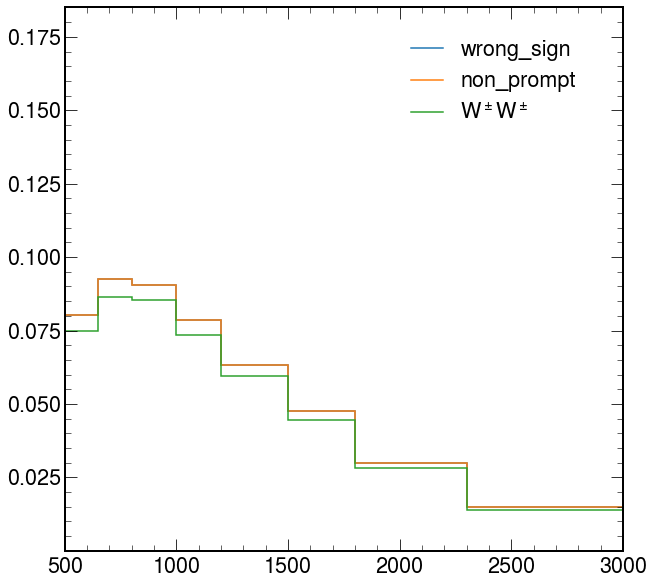

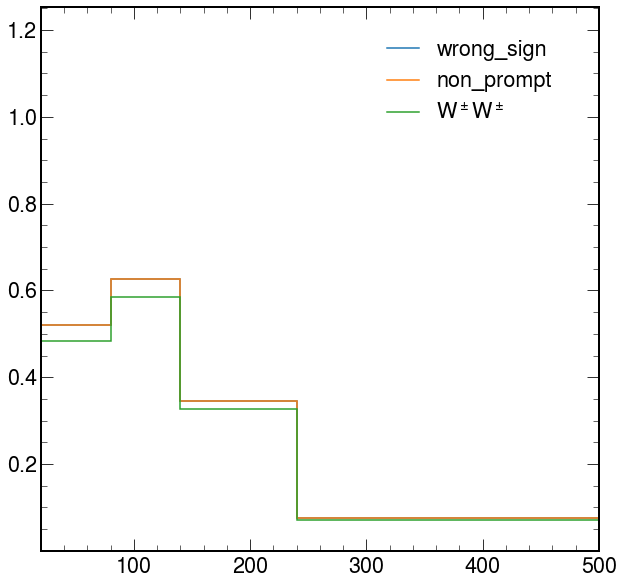

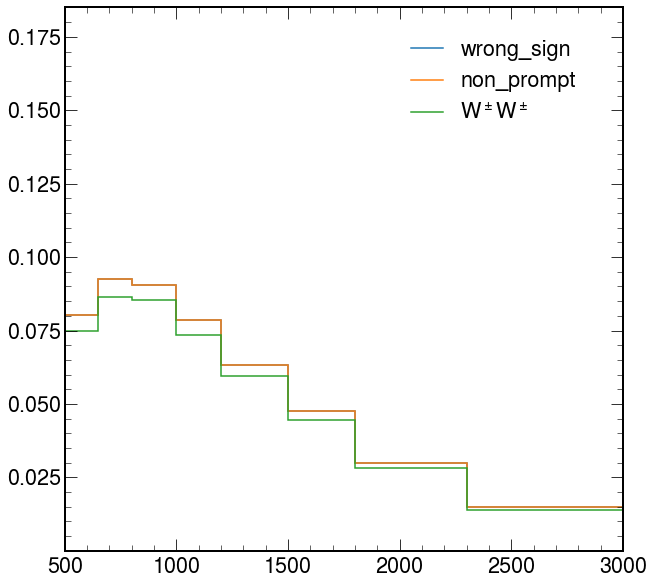

In [4]:
from yty_hist_class import yty_histplot

nanov7_dir = r'/data/pubfs/pku_visitor/public_write/download/datasets/nanov7'
with open(f"/data/pubfs/tyyang99/jupyter_files/test_datasets.yaml", 'r') as f:
    mc_yaml = yaml.load(f, Loader=yaml.FullLoader)
    
WW_merge = ['WpWpJJ_EWK', 'WpWpJJ_QCD']
WZ_EWK = ['WLLJJ_EWK']
WZ_merge = ['WZTo3LNu_0Jets_MLL_4to50','WZTo3LNu_1Jets_MLL_4to50','WZTo3LNu_2Jets_MLL_4to50','WZTo3LNu_3Jets_MLL_4to50',
           'WZTo3LNu_0Jets_MLL_50','WZTo3LNu_1Jets_MLL_50','WZTo3LNu_2Jets_MLL_50','WZTo3LNu_3Jets_MLL_50']
ZZ_merge = ['ZZJJTo4L_EWK','ZZJJTo4L_QCD','ZZJJTo4L_int','ggZZ_2e2mu',
           'ggZZ_2e2tau','ggZZ_2mu2tau','ggZZ_4e','ggZZ_4mu','ggZZ_4tau']
TVX_merge = ['TTGJets','TTZToQQ','TTZToLLNuNu_M_10',
             'TTWJetsToQQ','TTWJetsToLNu','tZq']
VG_merge = ['Zgamma_EWK','Wgamma_EWK','Wgamma_int']
WS_merge = ['WWTo2L2Nu',
            'ggWW_ee','ggWW_em','ggWW_et','ggWW_me','ggWW_mm','ggWW_mt','ggWW_te','ggWW_tm','ggWW_tt',
            'TTTo2L2Nu','ST_tW_top','ST_tW_antitop',
            'DYJetsToLL_M50','DYJets_M10to50','DYJets_M_10to50_ext','ggh_ww','ggh_zz','ggh_tautau',
            'VBF_HToZZTo4L','VBFHToWWTo2L2Nu','VBFHToTauTau',
            'ttHToNonbb','VHToNonbb']
Other_merge = ['WW_DS','WWW','WWZ','WZZ','ZZZ','WWG']

PROCESSES = [WW_merge, WZ_EWK, WZ_merge, ZZ_merge, TVX_merge, VG_merge, Other_merge]
# PROCESSES = [WW_merge, WZ_EWK]
legendlist = ['$W^\pm W^\pm$', 'WZ_EWK', 'WZ', 'ZZ', 'TVX', '$V\gamma$', 'Others']

test_merge = [['WpWpJJ_EWK']]
legendlist = ['$W^\pm W^\pm$']
# test_merge = [WW_merge, WZ_EWK]
# legendlist = ['$W^\pm W^\pm$','WZ_EWK']

nonprompt_mll_array_list = []
nonprompt_mll_weight_list = []
nonprompt_mjj_array_list = []
nonprompt_mjj_weight_list = []

nonprompt_label_list = []
wrong_sign_label_list = []
processes_label_list = []

wrong_sign_mll_array_list = []
wrong_sign_mll_weight_list = []
wrong_sign_mjj_array_list = []
wrong_sign_mjj_weight_list = []

default_mll_histbins = [20., 80., 140., 240., 500]
default_mjj_histbins = [500., 650., 800., 1000., 1200., 1500., 1800., 2300., 3000.]

mll_hist = yty_histplot('mll',1,default_mll_histbins)
mjj_hist = yty_histplot('mjj',1,default_mjj_histbins)

isdata = False
Lumi = 60.0*1e3

# print(os.listdir(nanov7_dir))
for i,process_list in enumerate(test_merge):
# for i,process_list in enumerate(PROCESSES):
    legend = legendlist[i]
    mll_array_list = []
    mll_weight_list = []
    mjj_array_list = []
    mjj_weight_list = []
    
    temp_nonprompt_mll_array_list = []
    temp_nonprompt_mll_weight_list = []
    temp_nonprompt_mjj_array_list = []
    temp_nonprompt_mjj_weight_list = []
    
    temp_wrong_sign_mll_array_list = []
    temp_wrong_sign_mll_weight_list = []
    temp_wrong_sign_mjj_array_list = []
    temp_wrong_sign_mjj_weight_list = []
    
    for process in process_list:
        print(process)
        process_dir = nanov7_dir + mc_yaml[process]['dataset']
        xs = mc_yaml[process]['xs']
        nevents = 0
        root_list = os.listdir(process_dir)
        for root_file in root_list:
            root_dir = process_dir+'/'+root_file
            print(root_file)
            events = NanoEventsFactory.from_root(root_dir, schemaclass=NanoAODSchema).events()
            
            nevents += np.sum(events.Generator.weight)
            
            if isdata==True:
                lumi_mask = ana.get_lumi_mask(events, '2018')
                events = events[lumi_mask]
            muons = events.Muon
            electrons = events.Electron
            jets = events.Jet
            # met = events.MET
            puppimet = events.PuppiMET
            
            #definition of loose or tight muons/electrons
            events['nmuons'] = np.sum(ak.ones_like(muons.pt),axis=1)
            events['nelectrons'] = np.sum(ak.ones_like(electrons.pt),axis=1)
            events['njets'] = np.sum(ak.ones_like(jets.pt),axis=1)
            events['nleps'] = events.nmuons+events.nelectrons

            muons['pt_orig'] = muons.pt
            muons['pt'],muons['pt_roccor_up'],muons['pt_roccor_down'] = ana.apply_rochester_correction(muons,data=isdata,year='2018')
            # electrons['corrected_pt'] = electrons.pt

            muon_ip = (abs(muons.dz)<0.1) & (((muons.pt<20) & (abs(muons.dxy)<0.01)) | ((muons.pt>20) & (abs(muons.dxy)<0.02)))
            loose_muon_sel = muon_ip & (muons.pt>10) & (abs(muons.eta)<2.4) & muons.tightId & (muons.pfRelIso04_all<0.4)
            tight_muon_sel = loose_muon_sel & (muons.pfRelIso04_all<0.15)

            if isdata==True:
                pass
            else:
                muons['is_real'] = (~np.isnan(ak.fill_none(muons.matched_gen.pt, np.nan)))*1

            muons['isloose'] = loose_muon_sel
            muons['istight'] = tight_muon_sel
            muons['istightcharge'] = (muons.tightCharge>1)
            muons['iselectron'] = ak.zeros_like(muons.pt)
            muons['ismuon'] = ak.ones_like(muons.pt)
            events['nloose_muons'] = np.sum(loose_muon_sel,axis=1)
            events['ntight_muons'] = np.sum(tight_muon_sel,axis=1)

            #election definition: the same as latino
            loose_elec_barrel = (abs(electrons.eta + electrons.deltaEtaSC) < 1.479) & (abs(electrons.dz) < 0.1) & (abs(electrons.dxy) < 0.05)
            loose_elec_endcap = (abs(electrons.eta + electrons.deltaEtaSC) > 1.479) & (abs(electrons.dz) < 0.2) & (abs(electrons.dxy) < 0.1) & (electrons.sieie < 0.03) & (electrons.eInvMinusPInv < 0.014)
            loose_elec_sel_pdgmva = (loose_elec_barrel | loose_elec_endcap) & (electrons.pt > 10) & (abs(electrons.eta+electrons.deltaEtaSC) < 2.5) & (electrons.cutBased >= 3)
            # loose_elec_sel_pdgmva = (loose_elec_barrel | loose_elec_endcap) & (electrons.pt > 10) & (abs(electrons.eta+electrons.deltaEtaSC) < 2.5) & (electrons.mvaFall17V2Iso_WP90)
            loose_elec_sel_drmu = ana.is_clean(electrons,muons,0.4)
            loose_elec_sel = loose_elec_sel_pdgmva & loose_elec_sel_drmu
            tight_elec_sel = loose_elec_sel & electrons.mvaFall17V2Iso_WP90 & (abs(electrons.pfRelIso03_all) < 0.06)

            electrons['isloose'] = loose_elec_sel
            electrons['istight'] = tight_elec_sel
            electrons['istightcharge'] = (electrons.tightCharge>1)
            electrons['iselectron'] = ak.ones_like(electrons.pt)
            electrons['ismuon'] = ak.zeros_like(electrons.pt)
            events['nloose_electrons'] = np.sum(loose_elec_sel,axis=1)
            events['ntight_electrons'] = np.sum(tight_elec_sel,axis=1)

            jets_drclean_elec = ana.is_clean(jets,electrons[electrons.isloose],0.4)
            jets_drclean_mu = ana.is_clean(jets,muons[muons.isloose],0.4)
            jets_drclean = jets_drclean_elec & jets_drclean_mu
            good_jets_sel = (jets_drclean) & (jets.pt > 20) & (abs(jets.eta)<4.7) & (jets.jetId>>1 & 1)
            good_jets_sel = good_jets_sel==1
            jets['isgood'] = good_jets_sel
            good_jets = jets[good_jets_sel]
            good_jets['pt_orig'] = good_jets.pt
            good_jets['mass_orig'] = good_jets.mass


            #####   JEC   #####
            if isdata==True:
                pass
            else:
                good_jets['is_real'] = (~np.isnan(ak.fill_none(good_jets.matched_gen.pt, np.nan)))*1
                good_jets["pt_raw"] = (1 - good_jets.rawFactor)*good_jets.pt
                good_jets["mass_raw"] = (1 - good_jets.rawFactor)*good_jets.mass
                good_jets["pt_gen"] = ak.values_astype(ak.fill_none(good_jets.matched_gen.pt, 0), np.float32)
                good_jets["rho"] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, good_jets.pt)[0]
                corrected_jets = ana.apply_jet_corrections('2018').build(good_jets, lazy_cache=events.caches[0])
                jesr_unc = [i for i in corrected_jets.fields if i.startswith("JES") or i.startswith("JER")]
                good_jets["pt"] = corrected_jets.pt
                good_jets["mass"] = corrected_jets.mass
                for ibr in jesr_unc:
                    good_jets[f"pt_{ibr}_up"] = corrected_jets[ibr].up.pt
                    good_jets[f"pt_{ibr}_down"] = corrected_jets[ibr].down.pt
                    good_jets[f"mass_{ibr}_up"] = corrected_jets[ibr].up.mass
                    good_jets[f"mass_{ibr}_down"] = corrected_jets[ibr].down.mass
                # ordered by new pt: high -> low
                index = ak.argsort(good_jets.pt, ascending=False)
                good_jets = good_jets[index]

            #####   btag   #####
            if isdata==True:
                pass
            else:
                flav = good_jets.hadronFlavour
                abseta = np.abs(good_jets.eta)
                pt = good_jets.pt
                good_jets['btagSF'], good_jets['btagSF_up'], good_jets['btagSF_down']  = ana.get_btagsf(flav, abseta, pt, '2018')
            events['ngood_jets'] = np.sum(good_jets_sel,axis=1)

            #####   MET   ####
            good_muons = muons[muons.isloose]
            good_electrons = electrons[electrons.isloose]
            MET = events.MET
            MET['pt_orig'] = MET.pt
            MET['phi_orig'] = MET.phi
            MET['pt_roccor'], MET['phi_roccor'] = ana.corrected_polar_met(MET.pt,MET.phi,good_muons.pt,good_muons.phi,good_muons.pt_orig)
            # consider the jer corr, please note: for jets, the pt_raw is the pt_orig, think about it
            if isdata==True:
                pass
            else:
                # the jer is applied after considering roccorr on Muon
                MET['pt'], MET['phi'] = ana.corrected_polar_met(MET['pt_roccor'],MET['phi_roccor'],good_jets["pt"],good_jets["phi"],good_jets["pt_orig"])
                # uncertainties
                MET['pt_roccor_up'], MET['phi_roccor_up'] = ana.corrected_polar_met(MET.pt,MET.phi,good_muons.pt_roccor_up,good_muons.phi,good_muons.pt)
                MET['pt_roccor_down'], MET['phi_roccor_down'] = ana.corrected_polar_met(MET.pt,MET.phi,good_muons.pt_roccor_down,good_muons.phi,good_muons.pt)
                MET['pt_UnclusteredEnergy_up'], MET['phi_UnclusteredEnergy_up'] = ana.corrected_polar_met(
                    MET['pt'],
                    MET['phi'],
                    good_jets["pt"],
                    good_jets["phi"],
                    good_jets["pt"],
                    (
                        True,
                        MET.MetUnclustEnUpDeltaX,
                        MET.MetUnclustEnUpDeltaY,
                    ),
                )
                MET['pt_UnclusteredEnergy_down'], MET['phi_UnclusteredEnergy_down'] = ana.corrected_polar_met(
                    MET['pt'],
                    MET['phi'],
                    good_jets["pt"],
                    good_jets["phi"],
                    good_jets["pt"],
                    (
                        False,
                        MET.MetUnclustEnUpDeltaX,
                        MET.MetUnclustEnUpDeltaY,
                    ),
                )
                for ibr in jesr_unc:
                    MET[f"pt_{ibr}_up"], MET[f"phi_{ibr}_up"] = ana.corrected_polar_met(MET['pt'],MET['phi'],good_jets[f"pt_{ibr}_up"],good_jets["phi"],good_jets["pt"])
                    MET[f"pt_{ibr}_down"], MET[f"phi_{ibr}_down"] = ana.corrected_polar_met(MET['pt'],MET['phi'],good_jets[f"pt_{ibr}_down"],good_jets["phi"],good_jets["pt"])
                    
            #ssww_cut_based

            #2lepton and multijets
            nleps_sel = events.nloose_muons+events.nloose_electrons==2
            njets_sel = events.ngood_jets>=2
            _2lnj_sel = nleps_sel & njets_sel

            #get selected objects
            sel_events = events[_2lnj_sel]
            sel_electrons = electrons[electrons.isloose][_2lnj_sel]
            sel_muons = muons[muons.isloose][_2lnj_sel]
            sel_leptons = ak.concatenate([sel_electrons,sel_muons],axis=1)
            sel_jets = good_jets[_2lnj_sel]

            #get 1e1mu, 2e, 2mu
            _2e_sel = (sel_events.nloose_electrons==2)
            _2m_sel = (sel_events.nloose_muons==2)
            _1e1mu_sel = (sel_events.nloose_electrons==1)

            #HLT for 1e1mu, 2e, 2mu
            # HLT_2e_sel = 
            # HLT_2m_sel = 
            # HLT_1e1mu_sel = 

            #get leading and subleading lepton and mll
            leading_lep_idx = ak.argmax(sel_leptons.pt,axis=1,keepdims=True)
            subleading_lep_idx = 1-leading_lep_idx
            sel_leptons_mll = (sel_leptons[:,0]+sel_leptons[:,1]).mass

            #lepton selection
            lep_pt_sel = (sel_leptons[leading_lep_idx].pt>25) & (sel_leptons[subleading_lep_idx].pt>20)
            lep_mll_sel = sel_leptons_mll>20
            lep_mllzz_sel = (_2e_sel & (abs(sel_leptons_mll-91.2)>15)) | ((1-_2e_sel)==1)
            lep_tc_sel = np.sum(sel_leptons.istightcharge,axis=1)==2
            MET_pt_sel = MET[_2lnj_sel].pt>30

            #jets variables definition
            leading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==0]
            subleading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==1]
            jet1_pt = leading_jet.pt
            jet1_eta = leading_jet.eta
            jet2_pt = subleading_jet.pt
            jet2_eta = subleading_jet.eta
            zf_2leps = abs(sel_leptons.eta-(jet1_eta+jet2_eta)[:,0]/2)/abs(jet1_eta-jet2_eta)[:,0]
            sel_jets_mjj = (leading_jet+subleading_jet).mass

            #jets selection
            jet_btag_sel = np.sum(sel_jets.btagDeepFlavB>0.2783,axis=1)<1
            jet_mjj_sel = (sel_jets_mjj>500)
            jet_deta_sel = abs(jet1_eta-jet2_eta)>2.5
            jet_pt_sel = (jet1_pt>50) & (jet2_pt>50)
            zf_sel = (zf_2leps[:,0] < 0.75) & (zf_2leps[:,1] < 0.75)

            #same-sign
            ss_sel = (abs(np.sum(sel_electrons.charge,axis=1)+np.sum(sel_muons.charge,axis=1))>0)
            os_sel = (abs(np.sum(sel_electrons.charge,axis=1)+np.sum(sel_muons.charge,axis=1))==0)
            # ss_2lnj_sel = nleps_sel & njets_sel & ss_sel
            # os_2lnj_sel = nleps_sel & njets_sel & os_sel

            #merge_selection_condition
            lep_merged_sel = lep_pt_sel & lep_mll_sel & lep_mllzz_sel & lep_tc_sel
            jet_merged_sel = jet_btag_sel & jet_mjj_sel & jet_deta_sel & jet_pt_sel
            ss_all_merged_sel = lep_merged_sel & jet_merged_sel & MET_pt_sel & zf_sel & ss_sel
            os_all_merged_sel = lep_merged_sel & jet_merged_sel & MET_pt_sel & zf_sel & os_sel

            events_after_sel = sel_events[ss_all_merged_sel[:,0]]
            electrons_after_sel = sel_electrons[ss_all_merged_sel[:,0]]
            muons_after_sel = sel_muons[ss_all_merged_sel[:,0]]
            leptons_after_sel = sel_leptons[ss_all_merged_sel[:,0]]
            jets_after_sel = sel_jets[ss_all_merged_sel[:,0]]
            
            #tight leptons
            print(len(leptons_after_sel))
            tight_leps_sel = (ak.sum(leptons_after_sel.istight,axis=1)==2)
            tight_leptons = leptons_after_sel[tight_leps_sel]
            tight_leptons_jets = jets_after_sel[tight_leps_sel]

            os_tight_leps_sel = (ak.sum(sel_leptons[os_all_merged_sel[:,0]].istight,axis=1)==2)
            os_tight_leptons = sel_leptons[os_all_merged_sel[:,0]][os_tight_leps_sel]
            os_tight_leptons_jets = sel_jets[os_all_merged_sel[:,0]][os_tight_leps_sel]

            not_both_tight_leptons = leptons_after_sel[tight_leps_sel==0]
            not_both_tight_leptons_jets = jets_after_sel[tight_leps_sel==0]
            print(np.sum(tight_leps_sel))
            print(np.sum(os_tight_leps_sel))
            
            pt1 = not_both_tight_leptons.pt[:,0]
            eta1 = not_both_tight_leptons.eta[:,0]
            pt2 = not_both_tight_leptons.pt[:,1]
            eta2 = not_both_tight_leptons.eta[:,1]
            iselectron1 = not_both_tight_leptons.iselectron[:,0]
            iselectron2 = not_both_tight_leptons.iselectron[:,1]
            istight1 = not_both_tight_leptons.istight[:,0]
            istight2 = not_both_tight_leptons.istight[:,1]
            nonp_weight = non_prompt_weight(pt1, eta1, pt2, eta2, iselectron1, iselectron2, istight1, istight2)
            nonp_weight = ak.Array(nonp_weight)

            cf_pt1 = os_tight_leptons.pt[:,0]
            cf_eta1 = os_tight_leptons.eta[:,0]
            cf_pt2 = os_tight_leptons.pt[:,1]
            cf_eta2 = os_tight_leptons.eta[:,1]
            cf_iselectron1 = os_tight_leptons.iselectron[:,0]
            cf_iselectron2 = os_tight_leptons.iselectron[:,1]
            cf_weight = charge_flip_weight(cf_pt1, cf_eta1, cf_pt2, cf_eta2, cf_iselectron1, cf_iselectron2)
            cf_weight = ak.Array(cf_weight)
            
            tight_leptons_mll = (tight_leptons[:,0]+tight_leptons[:,1]).mass
            non_prompt_mll = (not_both_tight_leptons[:,0]+not_both_tight_leptons[:,1]).mass
            wrong_sign_mll = (os_tight_leptons[:,0]+os_tight_leptons[:,1]).mass
            
            tight_leptons_mjj = (tight_leptons_jets[:,0]+tight_leptons_jets[:,1]).mass
            non_prompt_mjj = (not_both_tight_leptons_jets[:,0]+not_both_tight_leptons_jets[:,1]).mass
            wrong_sign_mjj = (os_tight_leptons_jets[:,0]+os_tight_leptons_jets[:,1]).mass
            
            temp_nonprompt_mll_array_list.append(non_prompt_mll)
            temp_nonprompt_mll_weight_list.append(nonp_weight)
            temp_nonprompt_mjj_array_list.append(non_prompt_mjj)
            temp_nonprompt_mjj_weight_list.append(nonp_weight)
            
            temp_wrong_sign_mll_array_list.append(wrong_sign_mll)
            temp_wrong_sign_mll_weight_list.append(cf_weight)
            temp_wrong_sign_mjj_array_list.append(wrong_sign_mjj)
            temp_wrong_sign_mjj_weight_list.append(cf_weight)
            
            mll_array_list.append(tight_leptons_mll)
            mll_weight_list.append(events_after_sel.Generator.weight[tight_leps_sel])
            mjj_array_list.append(tight_leptons_mjj)
            mjj_weight_list.append(events_after_sel.Generator.weight[tight_leps_sel])
    
    mc_weight = Lumi*xs/nevents
    mll_hist.append_values(process,mll_array_list)
    mll_hist.append_weights(process,np.array(mll_weight_list)*mc_weight)
    mjj_hist.append_values(process,mjj_array_list)
    mjj_hist.append_weights(process,np.array(mjj_weight_list)*mc_weight)
    
    mll_hist.append_values(process+'_nonprompt',temp_nonprompt_mll_array_list)
    mll_hist.append_weights(process+'_nonprompt',[ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight])
    mjj_hist.append_values(process+'_nonprompt',temp_nonprompt_mjj_array_list)
    mjj_hist.append_weights(process+'_nonprompt',[ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight])
    
    mll_hist.append_values(process+'_wrongsign',temp_wrong_sign_mll_array_list)
    mll_hist.append_weights(process+'_wrongsign',[ak.concatenate(temp_wrong_sign_mll_weight_list)*mc_weight])
    mjj_hist.append_values(process+'_wrongsign',temp_wrong_sign_mjj_array_list)
    mjj_hist.append_weights(process+'_wrongsign',[ak.concatenate(temp_wrong_sign_mjj_weight_list)*mc_weight])
    
    nonprompt_label_list.append(process+'_nonprompt')
    wrong_sign_label_list.append(process+'_wrongsign')
    
    mll_hist.merge([process],[process+'_nonprompt',process+'_wrongsign'],legend)
    mjj_hist.merge([process],[process+'_nonprompt',process+'_wrongsign'],legend)
    
    processes_label_list.append(legend)
    
    nonprompt_mll_array_list.append(ak.concatenate(temp_nonprompt_mll_array_list))
    nonprompt_mll_weight_list.append(ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight)
    nonprompt_mjj_array_list.append(ak.concatenate(temp_nonprompt_mjj_array_list))
    nonprompt_mjj_weight_list.append(ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight)
    
    wrong_sign_mll_array_list.append(ak.concatenate(temp_wrong_sign_mll_array_list))
    wrong_sign_mll_weight_list.append(ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight)
    wrong_sign_mjj_array_list.append(ak.concatenate(temp_wrong_sign_mjj_array_list))
    wrong_sign_mjj_weight_list.append(ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight)

mll_hist.merge(nonprompt_label_list,[],'non_prompt')
mjj_hist.merge(nonprompt_label_list,[],'non_prompt')

mll_hist.merge(wrong_sign_label_list,[],'wrong_sign')
mjj_hist.merge(wrong_sign_label_list,[],'wrong_sign')

processes_label_list.append('non_prompt')
processes_label_list.append('wrong_sign')

mll_hist.set_legend(legendbool=True)
mll_hist.draw(processes_label_list[:],stack=True)
mjj_hist.set_legend(legendbool=True)
mjj_hist.draw(processes_label_list[:],stack=True)



In [ ]:
mjj_hist.draw('wrong_sign')

In [ ]:
processes_label_list